In [33]:

# for data
import pandas as pd
from os import listdir
import os
from matplotlib import image
from matplotlib import pyplot as plt
import h5py
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
from os import listdir


In [34]:
# Counting labels
folder = "/home/afk/Documents/new/FQML/brain_tumor/" # .mat files folder
directs = sorted(listdir(folder))
labels = []
for file in directs:
    f = h5py.File('/home/afk/Documents/new/FQML/brain_tumor/'+file,'r')
    label = np.array(f.get("cjdata/label"))[0][0]
    labels.append(label)
labels = pd.Series(labels)
labels.shape

(3064,)

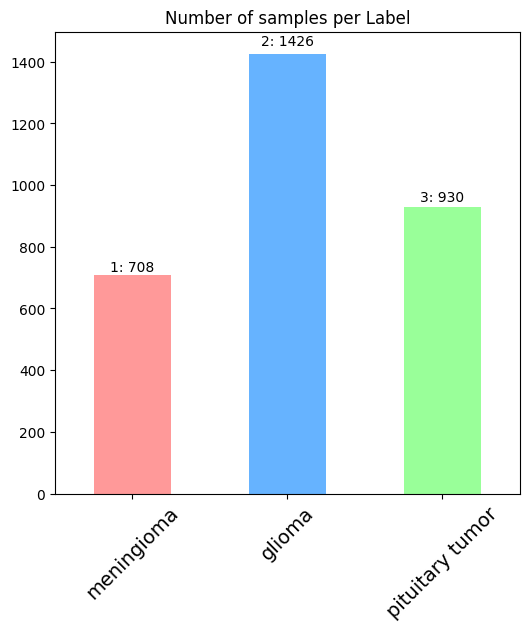

In [35]:
# Tumor types
names = ["meningioma", "glioma", "pituitary tumor"]
# Count labels
labelcounts = labels.value_counts().sort_index()
# change the index with th types
labelcounts.index = names

#print(labelcounts)

# create a barchart
ax = labelcounts.plot(
        kind='bar',
        figsize=(6, 6),
        width=0.5,
        color=['#ff9999', '#66b3ff', '#99ff99']  
     )

# define the title
ax.set_title("Number of samples per Label", size=12)
# change font size for labells an legend
plt.xticks(fontsize=14, rotation=45)

# putting the numbers
i = 1
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(str(i)+": "+str(height), (x + width/2, y + height*1.02), ha='center')
    i += 1

(3, 512, 512)


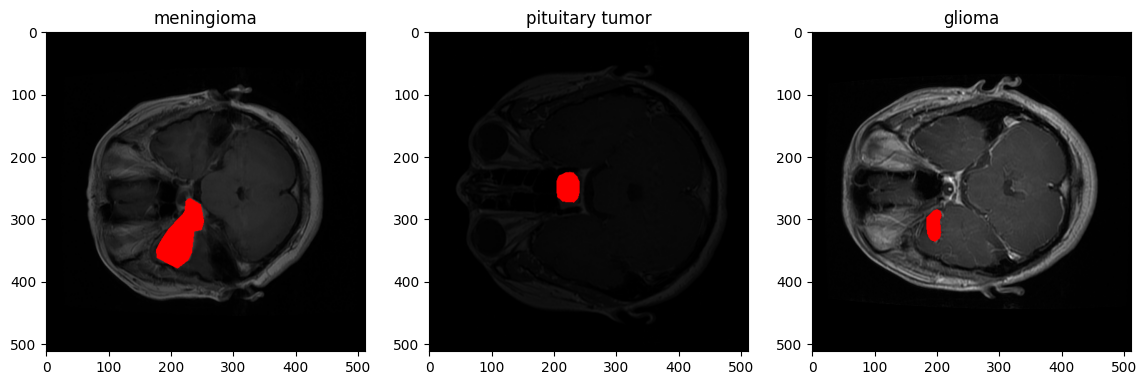

In [39]:
from tensorflow import keras as K
folder = "/home/afk/Documents/new/FQML/brain_tumor/" # .mat files folder
directs = sorted(listdir(folder))
labels = []
images = []
masks = []
for file in directs:
    f = h5py.File(folder+file,'r')
    label = np.array(f.get("cjdata/label"))[0][0]
    if label not in labels:
        #print(file)
        labels.append(label)
        img = np.stack((np.array(f.get("cjdata/image")),)*4, axis=-1)
        images.append(img)
        mask = np.array(f.get("cjdata/tumorMask"))
        masks.append(mask)
labels = np.asarray(labels)
images = np.asarray(images)
masks = np.asarray(masks)
labels.shape, images.shape, masks.shape

b = K.utils.to_categorical(masks, num_classes=4).astype(np.uint8)
tumor = np.zeros_like(images[:, :, :, 1:])
image_norm = cv2.normalize(images[:, :, :, 0], None, alpha=0, beta=255,
                      norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)

print(image_norm.shape)

# remove tumor part from image
tumor[:, :, :, 0] = image_norm * (b[:, :, :, 0])
tumor[:, :, :, 1] = image_norm * (b[:, :, :, 0])
tumor[:, :, :, 2] = image_norm * (b[:, :, :, 0])

# color tumor
tumor += b[:, :, :, 1:] * 255

tumor.shape
fig = plt.figure(figsize=(14, 10))
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(tumor[i], "gray")
    plt.title(names[int(labels[i]-1)])

plt.show()

Loaded images shape: (3049, 2, 2)
Loaded labels shape: (3049,)


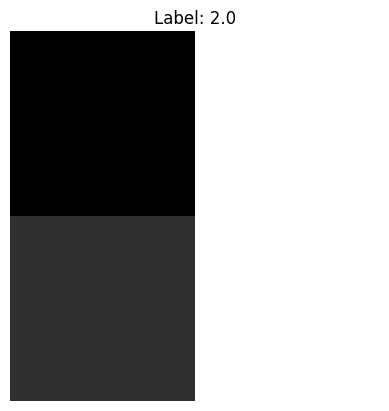

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Path to the .npz file
npz_file_path = '/home/afk/Documents/new/FQML/processed_new/processed_data.npz'

# Load the .npz file
data = np.load(npz_file_path)
images = data['images']
labels = data['labels']

# Print shapes of loaded data
print(f"Loaded images shape: {images.shape}")
print(f"Loaded labels shape: {labels.shape}")

# Choose an index to display
index = 1070  # Change this to display a different image

# Get the image and label
image = images[index]
label = labels[index]

# Display the image
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')  # Hide the axis
plt.show()


In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Path to the .npz file containing the processed images and labels
npz_file_path = '/home/afk/Documents/new/FQML/processed_new/processed_data.npz'

# Load the .npz file
dataset = np.load(npz_file_path)
images = dataset['images']
labels = dataset['labels']

# Print shapes of loaded data
print(f"Loaded images shape: {images.shape}")
print(f"Loaded labels shape: {labels.shape}")

# Flatten the images from shape (3049, 2, 2) to (3049, 4)
flattened_images = images.reshape(images.shape[0], -1)
print(f"Flattened images shape: {flattened_images.shape}")

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Perform a stratified split
train_images, test_images, train_labels, test_labels = train_test_split(
    flattened_images, 
    encoded_labels, 
    test_size=0.3,  # 30% of the data for testing
    stratify=encoded_labels,  # Ensures proportional splits
    random_state=42  # For reproducibility
)

np_data_set = [{'image': img, 'label': lbl} for img, lbl in zip(flattened_images, encoded_labels)]


# Assign variables for train and test datasets
training_data = {'images': train_images, 'labels': train_labels}
test_data = {'images': test_images, 'labels': test_labels}

# Print the shapes of the training and test datasets
print(f"Training images shape: {training_data['images'].shape}")
print(f"Training labels shape: {training_data['labels'].shape}")
print(f"Test images shape: {test_data['images'].shape}")
print(f"Test labels shape: {test_data['labels'].shape}")

# Count the number of instances of each label in the training and test datasets
train_label_counts = np.bincount(training_data['labels'])
test_label_counts = np.bincount(test_data['labels'])

print("\nLabel counts in the training dataset:")
for i, count in enumerate(train_label_counts):
    print(f"Label {i}: {count} instances")

print("\nLabel counts in the test dataset:")
for i, count in enumerate(test_label_counts):
    print(f"Label {i}: {count} instances")


Loaded images shape: (3049, 2, 2)
Loaded labels shape: (3049,)
Flattened images shape: (3049, 4)
Training images shape: (2134, 4)
Training labels shape: (2134,)
Test images shape: (915, 4)
Test labels shape: (915,)

Label counts in the training dataset:
Label 0: 496 instances
Label 1: 998 instances
Label 2: 640 instances

Label counts in the test dataset:
Label 0: 212 instances
Label 1: 428 instances
Label 2: 275 instances


In [2]:
np.random.shuffle(np_data_set)

print("First 5 samples of encoded shuffled data:")
print(np_data_set[:5])

First 5 samples of encoded shuffled data:
[{'image': array([0.43137255, 0.4745098 , 0.42745098, 0.47058824], dtype=float32), 'label': 1}, {'image': array([0.5372549 , 0.41568628, 0.5372549 , 0.41568628], dtype=float32), 'label': 1}, {'image': array([0.54509807, 0.49411765, 0.5411765 , 0.49411765], dtype=float32), 'label': 0}, {'image': array([0.7019608 , 0.5921569 , 0.6901961 , 0.61960787], dtype=float32), 'label': 0}, {'image': array([0.5568628, 0.5019608, 0.5529412, 0.5058824], dtype=float32), 'label': 1}]


In [21]:
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import BackendSampler
from functools import partial
#from qiskit import IBMQ
from qiskit.providers.basic_provider import BasicProvider


number_of_clients = 2   
epochs = 5  
max_train_iterations = 20
samples_per_epoch= 100
#backend = Aer.get_backend('aer_simulator')
backend = BasicProvider().get_backend("basic_simulator")


fl_avg_weight_range = [0.1, 1]


In [22]:

class Client:
    def __init__(self, dataset):
        self.models = []
        self.primary_model = None
        self.dataset = dataset
        self.test_scores = []
        self.train_scores = []

def distribute_data_to_clients(number_of_clients, epochs, samples_each_epoch, training_data):
    clients_list = []
    for client_index in range(number_of_clients):
        client_dataset = []
        for epoch_index in range(epochs):
            begin_index = (client_index * epochs * samples_each_epoch) + (epoch_index * samples_each_epoch)
            end_index = (client_index * epochs * samples_each_epoch) + ((epoch_index + 1) * samples_each_epoch)
            client_dataset.append({
                'images': training_data['images'][begin_index:end_index], 
                'labels': training_data['labels'][begin_index:end_index]
            })
        clients_list.append(Client(client_dataset))
    return clients_list

clients = distribute_data_to_clients(number_of_clients, epochs, samples_per_epoch, training_data)
for index, client in enumerate(clients):
    labels = client.dataset[0]['labels']  # Correctly access the 'labels' key
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    print(f"Client {index}, Epoch 0 - Labels: {dict(zip(unique_labels, label_counts))}")

clients[0].dataset[0]['images'][:5], clients[0].dataset[0]['labels'][:5]


Client 0, Epoch 0 - Labels: {0: 30, 1: 42, 2: 28}
Client 1, Epoch 0 - Labels: {0: 29, 1: 43, 2: 28}


(array([[0.43529412, 0.5254902 , 0.43529412, 0.54901963],
        [0.5411765 , 0.5921569 , 0.5529412 , 0.627451  ],
        [0.50980395, 0.4627451 , 0.5019608 , 0.47058824],
        [0.5176471 , 0.4745098 , 0.5529412 , 0.50980395],
        [0.56078434, 0.47843137, 0.5921569 , 0.5058824 ]], dtype=float32),
 array([0, 2, 2, 1, 1]))

In [23]:

example_client_data = clients[0].dataset[0]

# Loop through the first 5 images and labels
for index in range(5):
    # Retrieve the image and label at the current index
    image = example_client_data['images'][index]
    label = example_client_data['labels'][index]
    
    print(f"Shape of image at data point {index}: {image.shape}")
    print(f"Label for data point {index}: {label}")


Shape of image at data point 0: (4,)
Label for data point 0: 0
Shape of image at data point 1: (4,)
Label for data point 1: 2
Shape of image at data point 2: (4,)
Label for data point 2: 2
Shape of image at data point 3: (4,)
Label for data point 3: 1
Shape of image at data point 4: (4,)
Label for data point 4: 1


In [24]:


import time

iteration = 0

def training_callback(weights, obj_func_eval):
    global iteration
    iteration += 1
    print(f"{iteration}", end=' | ')

def train_model(dataset, model=None):
    # Ensure 'dataset' is a list of dictionaries with 'image' and 'label'
    if isinstance(dataset, list) and len(dataset) > 0 and 'image' in dataset[0] and 'label' in dataset[0]:
        images = [entry["image"] for entry in dataset]
        labels = [entry["label"] for entry in dataset]
    else:
        raise ValueError("Dataset must be a list of dictionaries with 'image' and 'label' keys.")
    
    # Convert the lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Print the shapes
    print("Shape of Training Images:", images.shape)
    print("Shape of Training Labels:", labels.shape)

    # Create a new model if one is not provided
    if model is None:
        num_features = images.shape[1]
        feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
        ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
        optimizer = COBYLA(maxiter=max_train_iterations)
        model = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
            callback=partial(training_callback),
            sampler=BackendSampler(backend=backend),
            warm_start=True
        )

    # Training
    print("Starting Training")
    start_time = time.time()
    model.fit(images, labels)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nTraining complete. Elapsed time: {elapsed_time} seconds.")

    # Scoring
    print("Evaluating Model Performance")
    train_score = model.score(images, labels)
    test_score = model.score(test_images, test_labels)

    return train_score, test_score, model



In [25]:



def calculate_accuracy(weights, test_sample_size=200):
    num_features = len(test_images[0])
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
    optimizer = COBYLA(maxiter=0)
    vqc_model = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        sampler=BackendSampler(backend=backend),
        initial_point=weights
    )
    vqc_model.fit(test_images[:25], test_labels[:25])
    return vqc_model.score(test_images[:test_sample_size], test_labels[:test_sample_size])

def initialize_model_with_weights(weights):
    num_features = len(test_images[0])
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
    optimizer = COBYLA(maxiter=max_train_iterations)
    vqc_model = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        sampler=BackendSampler(backend=backend),
        warm_start=True,
        initial_point=weights,
        callback=partial(training_callback)
    )
    return vqc_model


In [26]:
import warnings

# Temporary code to suppress all FutureWarnings for a cleaner output
warnings.simplefilter("ignore", FutureWarning)


In [27]:
import numpy as np


def average_weights_simple(epoch_results, last_epoch_weights=None, last_epoch_accuracy=None):
    if last_epoch_weights is not None:
        epoch_results['weights'].append(last_epoch_weights)
        epoch_results['test_scores'].append(last_epoch_accuracy)

    weights_list = epoch_results['weights']
    num_features = len(weights_list[0])
    averages = np.mean(weights_list, axis=0)
    
    return averages.tolist()


In [28]:

# Define the available averaging techniques with corresponding functions
averaging_techniques = {
    'Simple_Averaging': average_weights_simple
}

# Create a 2D array to hold client instances for each technique
clients_array_2d = [[] for _ in range(len(averaging_techniques))]

# Populate the 2D array with copies of clients for each technique
for idx, (technique_name, technique_function) in enumerate(averaging_techniques.items()):
    for client in clients:
        # Create a new Client instance with the same data for each technique
        client_copy = Client(client.dataset)
        clients_array_2d[idx].append(client_copy)

# Display the 2D array of clients
clients_array_2d


[[<__main__.Client at 0x7fd2457b4e60>, <__main__.Client at 0x7fd21978ddf0>]]

In [29]:
global_weights = []
global_accuracies = []

for technique_idx, clients_list in enumerate(clients_array_2d):
    technique_name = list(averaging_techniques.keys())[technique_idx]
    technique_function = list(averaging_techniques.values())[technique_idx]
    print(f"Technique: {technique_name}")

    # Initialize lists for storing global model weights and accuracies for this technique
    global_weights.append([])
    global_accuracies.append([])

    for epoch in range(epochs):
        epoch_results = {
            'weights': [],
            'test_scores': []
        }
        print(f"Epoch: {epoch}")

        for client_idx, client in enumerate(clients_list):
            print(f"Client Index: {client_idx}, Client Data: {client}")

            # Prepare client data
            client_data = [{'image': img, 'label': lbl} for img, lbl in zip(client.dataset[epoch]['images'], client.dataset[epoch]['labels'])]

            if client.primary_model is None:
                # Train a new model
                train_score, test_score, model = train_model(dataset=client_data)
                client.models.append(model)
                client.test_scores.append(test_score)
                client.train_scores.append(train_score)
                print(f"Train Score: {train_score}")
                print(f"Test Score: {test_score}\n\n")
                epoch_results['weights'].append(model.weights)
                epoch_results['test_scores'].append(test_score)
            else:
                # Continue training with the existing model
                train_score, test_score, model = train_model(dataset=client_data, model=client.primary_model)
                client.models.append(model)
                client.test_scores.append(test_score)
                client.train_scores.append(train_score)
                print(f"Train Score: {train_score}")
                print(f"Test Score: {test_score}\n\n")
                epoch_results['weights'].append(model.weights)
                epoch_results['test_scores'].append(test_score)

        # Compute new global model weights based on the chosen technique
        if epoch == 0:
            new_weights = technique_function(epoch_results)
        else:
            previous_weights = global_weights[technique_idx][epoch - 1]
            previous_accuracy = global_accuracies[technique_idx][epoch - 1]
            new_weights = technique_function(epoch_results, previous_weights, previous_accuracy)
        
        print(f"New Global Weights: {new_weights}")
        global_weights[technique_idx].append(new_weights)
        
        # Create a new model with the computed global weights
        model_with_global_weights = initialize_model_with_weights(global_weights[technique_idx][epoch])

        for client in clients_list:
            client.primary_model = model_with_global_weights

        # Evaluate the new global model
        global_accuracy = calculate_accuracy(global_weights[technique_idx][epoch], len(test_images))
        global_accuracies[technique_idx].append(global_accuracy)
        print(f"Technique: {technique_name}")
        print(f"Global Model Accuracy at Epoch {epoch}: {global_accuracy}")
        print("----------------------------------------------------------")


Technique: Simple_Averaging
Epoch: 0
Client Index: 0, Client Data: <__main__.Client object at 0x7fd2457b4e60>
Shape of Training Images: (100, 4)
Shape of Training Labels: (100,)
Starting Training
1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 
Training complete. Elapsed time: 89.45307803153992 seconds.
Evaluating Model Performance
Train Score: 0.45
Test Score: 0.49398907103825135


Client Index: 1, Client Data: <__main__.Client object at 0x7fd21978ddf0>
Shape of Training Images: (100, 4)
Shape of Training Labels: (100,)
Starting Training
21 | 22 | 23 | 24 | 25 | 26 | 27 | 28 | 29 | 30 | 31 | 32 | 33 | 34 | 35 | 36 | 37 | 38 | 39 | 40 | 
Training complete. Elapsed time: 14.381324768066406 seconds.
Evaluating Model Performance
Train Score: 0.48
Test Score: 0.47650273224043715


New Global Weights: [1.5878200653093657, 1.2070675830501738, 0.5743717368414095, 0.34506548778018276, 1.2595752363963317, 0.4072608437623362, 1.0717091222796489, 1.80996

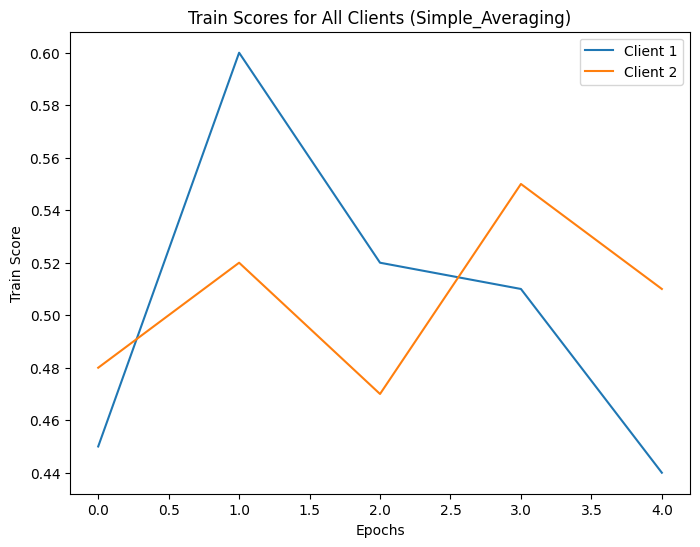

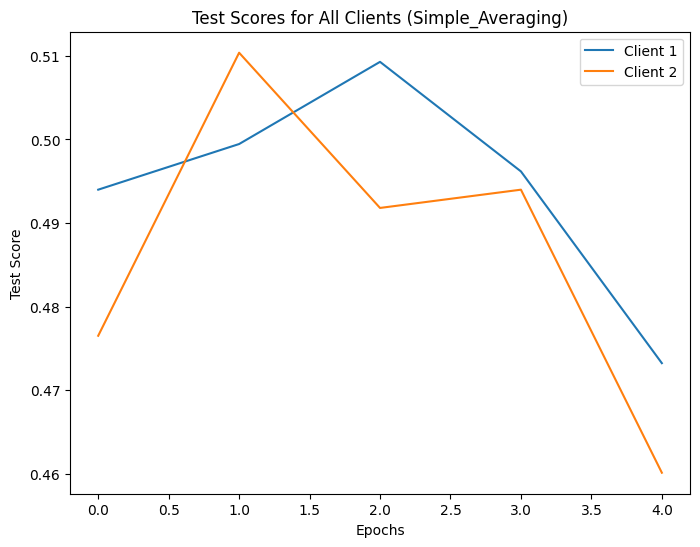

In [30]:
import matplotlib.pyplot as plt

# Create plots for train scores and test scores for each technique
for technique_idx, clients_list in enumerate(clients_array_2d):
    technique_name = list(averaging_techniques.keys())[technique_idx]

    # Plot train scores for all clients
    plt.figure(figsize=(8, 6))
    for client_idx, client in enumerate(clients_list):
        plt.plot(client.train_scores, label=f'Client {client_idx + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Train Score')
    plt.title(f"Train Scores for All Clients ({technique_name})")
    plt.legend()
    plt.show()

    # Plot test scores for all clients
    plt.figure(figsize=(8, 6))
    for client_idx, client in enumerate(clients_list):
        plt.plot(client.test_scores, label=f'Client {client_idx + 1}')
    plt.xlabel('Epochs')
    plt.ylabel('Test Score')
    plt.title(f"Test Scores for All Clients ({technique_name})")
    plt.legend()
    plt.show()


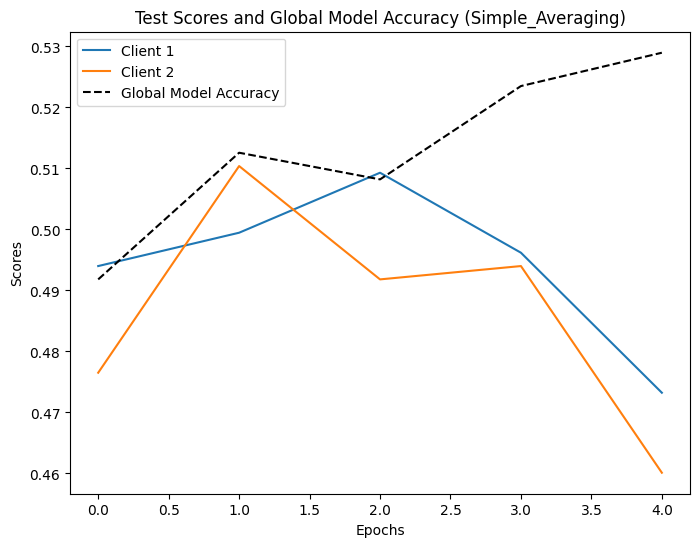

In [31]:
import matplotlib.pyplot as plt

# Create plots for test scores and global model accuracy for each technique
for technique_idx, clients_list in enumerate(clients_array_2d):
    technique_name = list(averaging_techniques.keys())[technique_idx]

    # Create a new figure for test scores and global model accuracy
    plt.figure(figsize=(8, 6))

    # Plot test scores for all clients
    for client_idx, client in enumerate(clients_list):
        plt.plot(client.test_scores, label=f'Client {client_idx + 1}')

    # Plot global model accuracy
    plt.plot(global_accuracies[technique_idx], label='Global Model Accuracy', linestyle='--', color='black')

    plt.xlabel('Epochs')
    plt.ylabel('Scores')
    plt.title(f"Test Scores and Global Model Accuracy ({technique_name})")
    plt.legend()

    # Show the combined graph
    plt.show()
